In [1]:
import os
import socket
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import Bucketizer, QuantileDiscretizer
from pyspark.sql import Window
from pyspark.sql.types import *

In [2]:
try:
    spark
except NameError:
    spark = SparkSession.builder.appName("").getOrCreate()

In [3]:
if 'samuel' in socket.gethostname().lower():
    path_to_data = '../../data'
else:
    path_to_data = '/user/spf248/twitter/data'

In [4]:
print('Path to data:',path_to_data) 
country_code = "US"
print('Country:', country_code)
iterations=range(2)
models=['GLOVE','BERT']
labels=['is_hired_1mo', 'is_unemployed', 'job_offer', 'job_search', 'lost_job_1mo']
keywords=['fired', 'hired', 'job', 'laid_off', 'position', 'quit', 'unemployed', 'work']
targets=[
'target_anyone_hiring',
'target_here_is_a_job_opportunity_you_might_be_interested_in',
'target_i_am_currently_not_working',
'target_i_am_searching_for_a_new_position',
'target_i_got_hired_today',
'target_i_lost_my_job_today',
'target_i_recently_started_working_at_my_new_job',
'target_i_was_fired_earlier_this_week',
'target_looking_for_a_new_position',
'target_now_i_am_unemployed']

base_rates=[
1.7342911457049017e-05,
0.0003534645020523677,
0.005604641971672389,
0.00015839552996469054,
1.455338466552472e-05]
N_random=92114009
base_ranks=[int(x*N_random) for x in base_rates]
label2rank=dict(zip(labels,base_ranks))

Path to data: ../../data
Country: US


In [5]:
label2rank

{'is_hired_1mo': 1597,
 'is_unemployed': 32559,
 'job_offer': 516266,
 'job_search': 14590,
 'lost_job_1mo': 1340}

In [ ]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

In [ ]:
# random_tweets = spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'random-scored'))
# df = random_tweets.select('tweet_id','text')
# pre_process_udf = F.udf(lambda x:text_processor.pre_process_doc(x), ArrayType(StringType()))
# df = df.withColumn('tokens', pre_process_udf('text'))
# word_count = df.select(F.explode("tokens").alias("word")).groupBy("word").count()
# word_count.write.mode("overwrite").parquet(os.path.join(path_to_data,'classification',country_code,'word_count','random'))

In [ ]:
random_tweets = spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'random-scored'))
word_count = spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'word_count','random'))
pre_process_udf = F.udf(lambda x:text_processor.pre_process_doc(x), ArrayType(StringType()))

In [ ]:
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            predictions=spark.read.option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'predictions','iteration_'+str(iteration),model,label,'random*'))
            df=predictions.withColumnRenamed('proba','score').withColumnRenamed('second','score').select('tweet_id','score')
            df=df.withColumn('score',F.col('score').cast('float'))
            df=df.join(random_tweets.select('tweet_id','text'),on='tweet_id')
            df=df.sort(F.col("score").desc()).limit(label2rank[label])
            df=df.withColumn('tokens', pre_process_udf('text'))
            df_word_count=df.select(F.explode("tokens").alias("word")).groupBy("word").count().withColumnRenamed('count','count_top_tweets')
            df_word_count=df_word_count.join(word_count,on='word')
            df_word_count.coalesce(1).write.mode("overwrite").parquet(os.path.join(path_to_data,'classification',country_code,'word_count','iteration_'+str(iteration),model,label))

# Figures

In [68]:
word_counts={}
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            name='iteration_'+str(iteration)+'-'+model+'-'+label
            word_counts[name]=spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'word_count','iteration_'+str(iteration),model,label)).toPandas()


********* Iteration: 0 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

********* Iteration: 1 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***



****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***


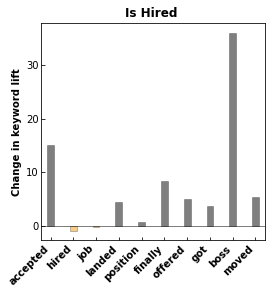

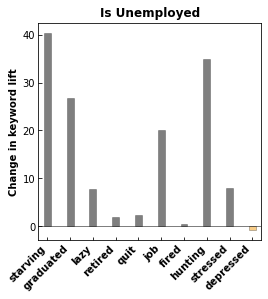

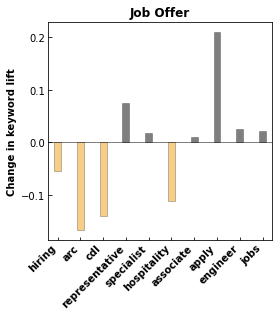

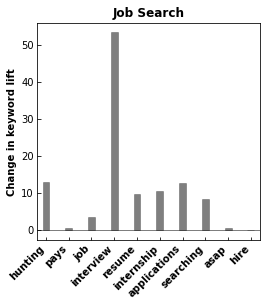

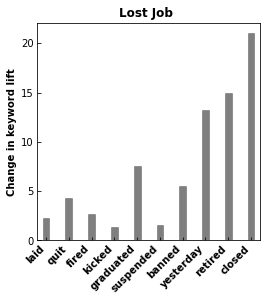

In [89]:
N_cutoff=10000
word_cutoff=10
y='lift_change'
x='rank_1'
delta={}
for model in models[1:]:
    print()
    print('****** Model:',model,'******')
    for label in labels:
        print('*** Label:',label,'***')
        
        df0=word_counts['iteration_0'+'-'+model+'-'+label].copy()
        df0['lift']=df0['count_top_tweets'].divide(df0['count'])*N_random/label2rank[label]
        df0=df0[df0['count']>=N_cutoff].copy()
        
        df1=word_counts['iteration_1'+'-'+model+'-'+label].copy()
        df1['lift']=df1['count_top_tweets'].divide(df1['count'])*N_random/label2rank[label]
        df1=df1[df1['count']>=N_cutoff].copy()
        
        delta[model+'-'+label]=df0.merge(df1,on='word',suffixes=['_0','_1']).dropna()
        delta[model+'-'+label].sort_values(by='lift_0',ascending=False,inplace=True)
        delta[model+'-'+label]=delta[model+'-'+label].reset_index(drop=True).reset_index().rename(columns={'index':'rank_0'})
        delta[model+'-'+label].sort_values(by='lift_1',ascending=False,inplace=True)
        delta[model+'-'+label]=delta[model+'-'+label].reset_index(drop=True).reset_index().rename(columns={'index':'rank_1'})
        delta[model+'-'+label]['rank_change']=delta[model+'-'+label]['rank_0'].subtract(delta[model+'-'+label]['rank_1'])
        delta[model+'-'+label]['lift_change']=delta[model+'-'+label]['lift_1'].divide(delta[model+'-'+label]['lift_0'])-1
        delta[model+'-'+label]=delta[model+'-'+label].sort_values(by=x).head(word_cutoff)
        delta[model+'-'+label]['sign_y']=(delta[model+'-'+label][y]>=0)
        
        fig,ax = plt.subplots(figsize=(4,4))
        delta[model+'-'+label].plot(ax=ax,y=y,x=x,kind='bar',legend=False,color=delta[model+'-'+label]['sign_y'].map({True: 'k', False: '#f39c12'}),edgecolor='k',linewidth=.5,alpha=.5,width=.3)
        ax.set_xticklabels(delta[model+'-'+label]['word'],rotation=45,ha='right',fontweight='bold')
        ax.tick_params(which='both',direction='in',pad=3)
        ax.set_xlabel('')
        ax.set_ylabel('Change in keyword lift',fontweight='bold')
        ax.set_title(label.replace('_',' ').replace('1mo','').title(),fontweight='bold')
        ax.locator_params(axis='y',nbins=6)
        ax.axhline(0,linewidth=.5,color='k',linestyle='-')
        plt.savefig(os.path.join(path_to_data,'../fig','keywords_expansion_'+model+'_'+label+'.pdf'),bbox_inches='tight')